In [1]:
import random
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque

In [2]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)

        self.priorities[self.position] = max_prio
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        batch = list(zip(*samples))

        states = np.array(batch[0])
        actions = np.array(batch[1])
        rewards = np.array(batch[2])
        next_states = np.array(batch[3])
        dones = np.array(batch[4])

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio



class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, env, buffer, batch_size=64, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500):
        self.env = env
        self.buffer = buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start
        self.steps_done = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.update_target()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def select_action(self, state):
        self.steps_done += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-1. * self.steps_done / self.epsilon_decay)
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                return self.policy_net(state).argmax().item()
        else:
            return self.env.action_space.sample()

    def train_step(self):
        if len(self.buffer.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones, indices, weights = self.buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = (weights * (q_values - expected_q_values.detach()).pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        priorities = (q_values - expected_q_values).abs().cpu().detach().numpy() + 1e-5
        self.buffer.update_priorities(indices, priorities)

    def save(self, filename):
        torch.save(self.policy_net.state_dict(), filename)

    def load(self, filename, map_location=None):
        self.policy_net.load_state_dict(torch.load(filename, map_location=map_location))
        self.update_target()

### 4. Train the Agent

env = gym.make("LunarLander-v2")
buffer = PrioritizedReplayBuffer(10000)

agent = DQNAgent(env, buffer)

num_episodes = 2000
target_update_freq = 10

rewards = []
path = 'per.pth'

try:
    map_location = torch.device('cpu') if not torch.cuda.is_available() else None
    agent = agent.load(path,map_location=map_location)
except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")
    
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(1000):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.train_step()

        if done:
            break
    rewards.append(total_reward)

    print(f"Episode {episode}, Total Reward: {total_reward}")

    if episode % target_update_freq == 0:
        agent.update_target()
        agent.save(path)

    if episode > 100 and sum(rewards[-5:]) > 1000:
        agent.save(path)
        print(f'\nEnvironment solved in {episode} episodes!')
        break

    

env.close()


/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


No checkpoint found, starting from scratch.


/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: -148.53575209601794
Episode 1, Total Reward: -19.073315808061906
Episode 2, Total Reward: -122.98573835826983
Episode 3, Total Reward: -168.64580937321693
Episode 4, Total Reward: -583.8710028444107
Episode 5, Total Reward: -309.86598801685216
Episode 6, Total Reward: -458.1347075285098
Episode 7, Total Reward: -324.0121081472578
Episode 8, Total Reward: -258.1740769606761
Episode 9, Total Reward: -255.55172749496919
Episode 10, Total Reward: -352.12358744371966
Episode 11, Total Reward: -270.98246190990545
Episode 12, Total Reward: -361.66515604185975
Episode 13, Total Reward: -187.06438554297404
Episode 14, Total Reward: -124.58780391056628
Episode 15, Total Reward: -393.97275793412257
Episode 16, Total Reward: -549.4757553722334
Episode 17, Total Reward: -397.3850822745982
Episode 18, Total Reward: -131.30941767062365
Episode 19, Total Reward: -87.40684645788825
Episode 20, Total Reward: -108.26346329934499
Episode 21, Total Reward: -214.3537904260668
Episod

KeyboardInterrupt: 

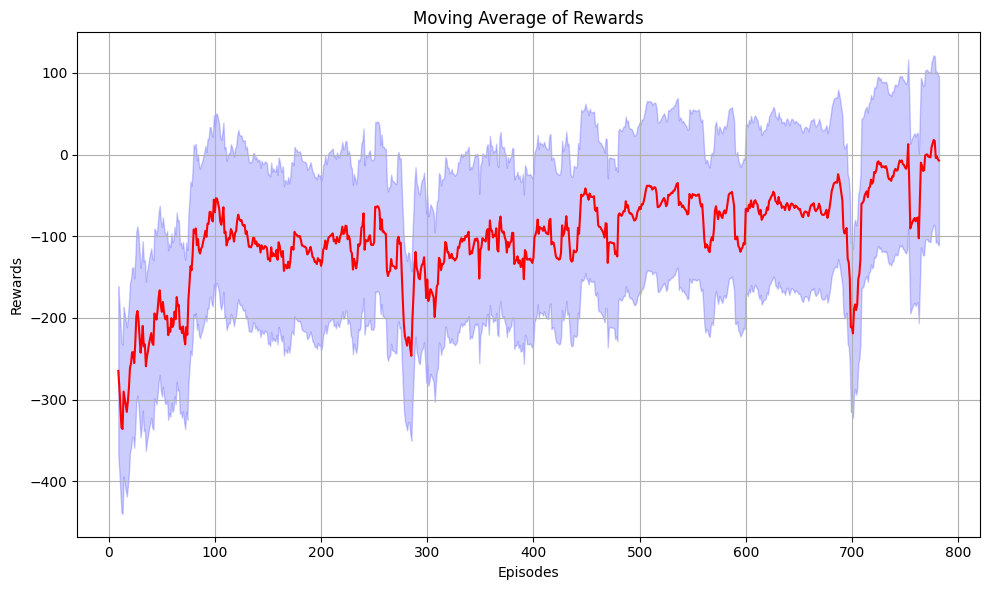

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(0)
data = rewards

# Calculate the moving average
window_size = 10
moving_avg = pd.Series(data).rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the moving average line
sns.lineplot(data=moving_avg, color='red')

# Shade the area around the moving average line to represent the range of values
plt.fill_between(range(len(moving_avg)),
                 moving_avg - np.std(data),
                 moving_avg + np.std(data),
                 color='blue', alpha=0.2)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Moving Average of Rewards')
plt.grid(True)
# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Episode_rewards.png')
# Show the plot
plt.show()